## Simple Moving Average

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('DATA FILE 334 (2).xlsx')
df.columns

Index([             'Part ID',    'Planning Leadtime',         'Order Policy',
                'Order Point',     'Safety Stock Qty',      'Fixed Order Qty',
             'Days Of Supply',    'Minimum Order Qty',    'Maximum Order Qty',
         'Multiple Order Qty',                  'Fab',                  'Pur',
                    'Stocked',          'Detail Only',              'Purc Lt',
                   'Abc Code',     'Inventory Locked',           'Inventory$',
         'Unit Material Cost',     'Annual Usage Qty',        'Prev Yr Usage',
             'Roll Ann Usage',          'Qty On Hand',    'Qty Available Mrp',
                   'TotAlloc',           'Coeff_Code',             'Stock Um',
           'Def Orig Country',       'Primary Whs Id',       'Primary Loc Id',
         'Annual Usage Value',       2666342.46838269,             'Profit %',
       'Cummulatove Profit %',           'Jan (2018)',           'Feb (2018)',
                 'Mar (2018)',           'Apr (2018)

### Accuracy in Forecasting

In [4]:
# all
start_index, end_index = 34, 58

Using historical data (2018) to build the model and then test its accuracy on future data (2019).

In [5]:
# Identify the indices for columns corresponding to 2018 and 2019
start_index_2018 = df.columns.get_loc("Jan (2018)")
end_index_2018 = df.columns.get_loc("Dec (2018)")
start_index_2019 = df.columns.get_loc("Jan (2019)")
end_index_2019 = df.columns.get_loc("Dec (2019)")

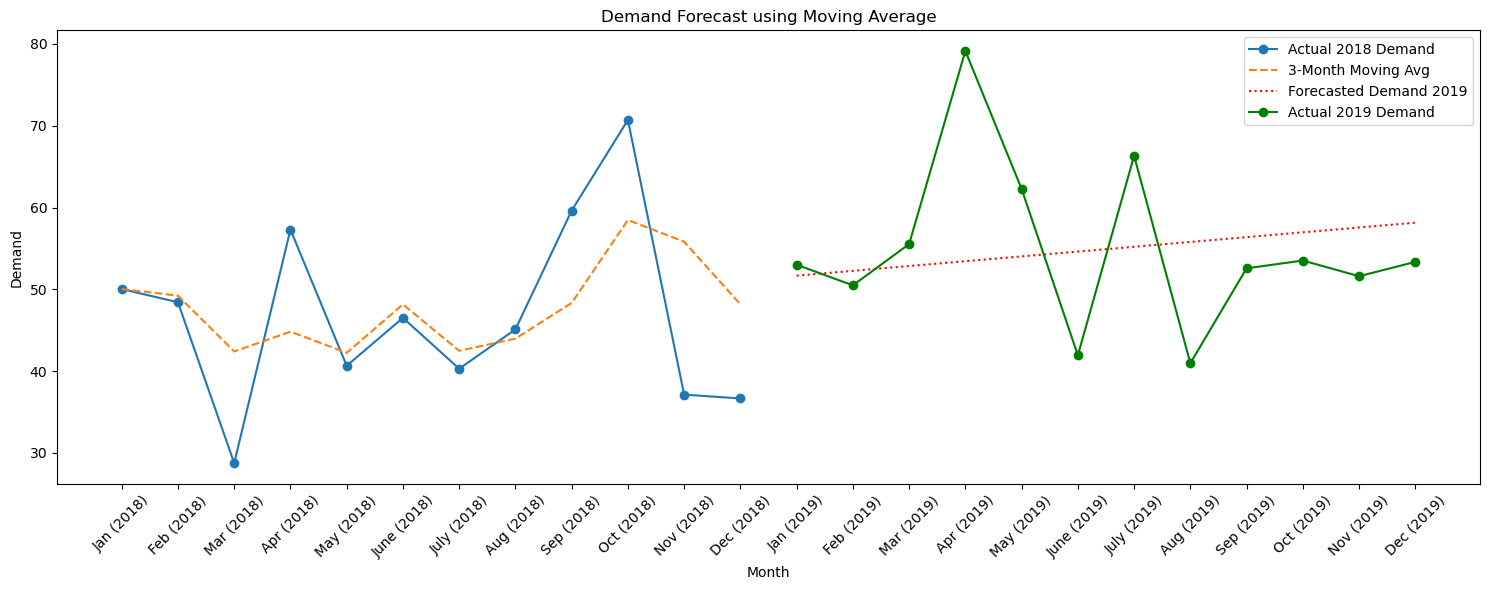

In [6]:
from sklearn.linear_model import LinearRegression

window_size = 3

# Calculate the moving average on the training data (2018)
train_data = df.iloc[:, start_index_2018:end_index_2018+1].mean(axis=0)
train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean().dropna()

# Fit a linear model to the moving averages
time_index = np.arange(len(train_moving_avg)).reshape(-1, 1)
model = LinearRegression().fit(time_index, train_moving_avg)

# Forecast moving averages for 2019 using the linear model
forecast_length = end_index_2019 - start_index_2019 + 1
forecast_time_index = np.arange(len(train_moving_avg), len(train_moving_avg) + forecast_length).reshape(-1, 1)
forecast_moving_avg = model.predict(forecast_time_index)

# Prepare the forecast series
test_forecast = pd.Series(forecast_moving_avg.flatten(), index=df.columns[start_index_2019:end_index_2019+1])

# Assuming 'test_data' contains the actual demand for 2019
test_data = df.iloc[:, start_index_2019:end_index_2019+1].mean(axis=0)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.columns[start_index_2018:end_index_2018+1], train_data, label='Actual 2018 Demand', marker='o')
plt.plot(df.columns[start_index_2018:end_index_2018+1], train_moving_avg, label='3-Month Moving Avg', linestyle='--')
plt.plot(test_forecast.index, test_forecast, label='Forecasted Demand 2019', color='red', linestyle=':')
plt.plot(df.columns[start_index_2019:end_index_2019+1], test_data, label='Actual 2019 Demand', marker='o', color='green', zorder=5)

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Demand Forecast using Moving Average')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

# Forecast Error (Actual - Predicted)
forecast_errors = test_data - test_forecast

# Mean Absolute Deviation (MAD)
mad = forecast_errors.abs().mean()

# Mean Squared Error (MSE)
mse = mean_squared_error(test_data, test_forecast)

# Mean Absolute Percentage Error (MAPE)
mape = (forecast_errors.abs() / test_data).mean() * 100

print(f"Forecasted Values: {forecast_errors}")
print(f"MAD: {mad}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")

Forecasted Values: Jan (2019)      1.332157
Feb (2019)     -1.774974
Mar (2019)      2.684623
Apr (2019)     25.698534
May (2019)      8.244697
June (2019)   -12.677557
July (2019)    11.118338
Aug (2019)    -14.818826
Sep (2019)     -3.813194
Oct (2019)     -3.447312
Nov (2019)     -5.954763
Dec (2019)     -4.793402
dtype: float64
MAD: 8.029864818484262
MSE: 110.7764912487142
MAPE: 14.495810617044134


### On a Product Level

#### Repeaters (First 10 Products)

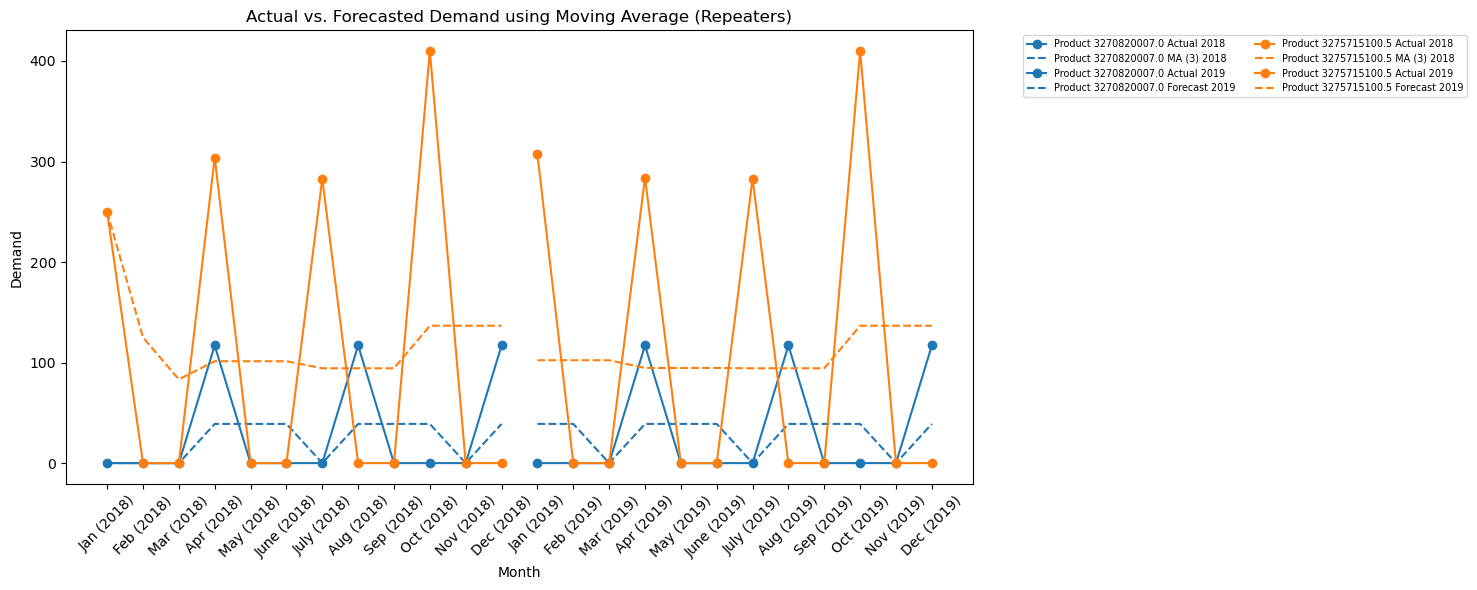

Average MAD for first 10 products: 90.83333333333333
Average MSE for first 10 products: 12893.361111111111
Average MAPE for first 10 products: inf


In [8]:
from sklearn.linear_model import LinearRegression

# Filter for 'Repeater' products
df_repeaters = df[df['Coeff_Code'] == 'Repeater'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_repeaters.columns.get_loc("Jan (2018)")
end_index_2018 = df_repeaters.columns.get_loc("Dec (2018)")
start_index_2019 = df_repeaters.columns.get_loc("Jan (2019)")
end_index_2019 = df_repeaters.columns.get_loc("Dec (2019)")

# Initialize a plot
plt.figure(figsize=(15, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10)) 

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_repeaters.iterrows():
    # Skip product 3271255000
    # if product_id == 3271255000.5:
    #     continue
    # if num_products_processed < 10:
    if product_id in (3275715100.5, 3270820007.0):
        # Get the color for the current product
        color = colors[num_products_processed % len(colors)]

        # Calculate the moving average for 2018
        numeric_data = pd.to_numeric(row, errors='coerce').fillna(0)

        data_2018 = numeric_data[start_index_2018:end_index_2018+1]
        data_2019 = numeric_data[start_index_2019:end_index_2019+1]
        
        if not train_data.dropna().empty:
            # Compute moving average for 2018 and extend this logic into 2019
            combined_data = pd.concat([data_2018, data_2019])
            moving_avg_combined = combined_data.rolling(window=window_size, min_periods=1).mean()

            # Separate the moving average into 2018 and 2019 for clarity
            moving_avg_2018 = moving_avg_combined.iloc[:len(data_2018)]
            forecast_2019 = moving_avg_combined.iloc[len(data_2018):]
            
            # Plot training data and moving average
            plt.plot(combined_data.index[:len(data_2018)], data_2018, marker='o', linestyle='-', color=color, label=f'Product {product_id} Actual 2018')
            plt.plot(data_2018.index, moving_avg_2018, linestyle='--', color=color, label=f'Product {product_id} MA (3) 2018')
            plt.plot(combined_data.index[len(data_2018):], data_2019, marker='o', linestyle='-', color=color, label=f'Product {product_id} Actual 2019')
            plt.plot(combined_data.index[len(data_2018):], forecast_2019, linestyle='--', color=color, label=f'Product {product_id} Forecast 2019')

           # Calculate errors
            errors = data_2019.values - forecast_2019
            
            # Calculate MAD, MSE, MAPE
            mad = np.mean(np.abs(errors))
            mse = np.mean(errors**2)
            mape = np.mean(np.abs(errors / data_2019.values)) * 100
            
            # Store the calculated metrics
            mad_list.append(mad)
            mse_list.append(mse)
            mape_list.append(mape)
    
        # Increment the counter
        num_products_processed += 1

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand using Moving Average (Repeaters)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first 10 products: {average_mad}')
print(f'Average MSE for first 10 products: {average_mse}')
print(f'Average MAPE for first 10 products: {average_mape}')

#### Runners (First 10 Products)

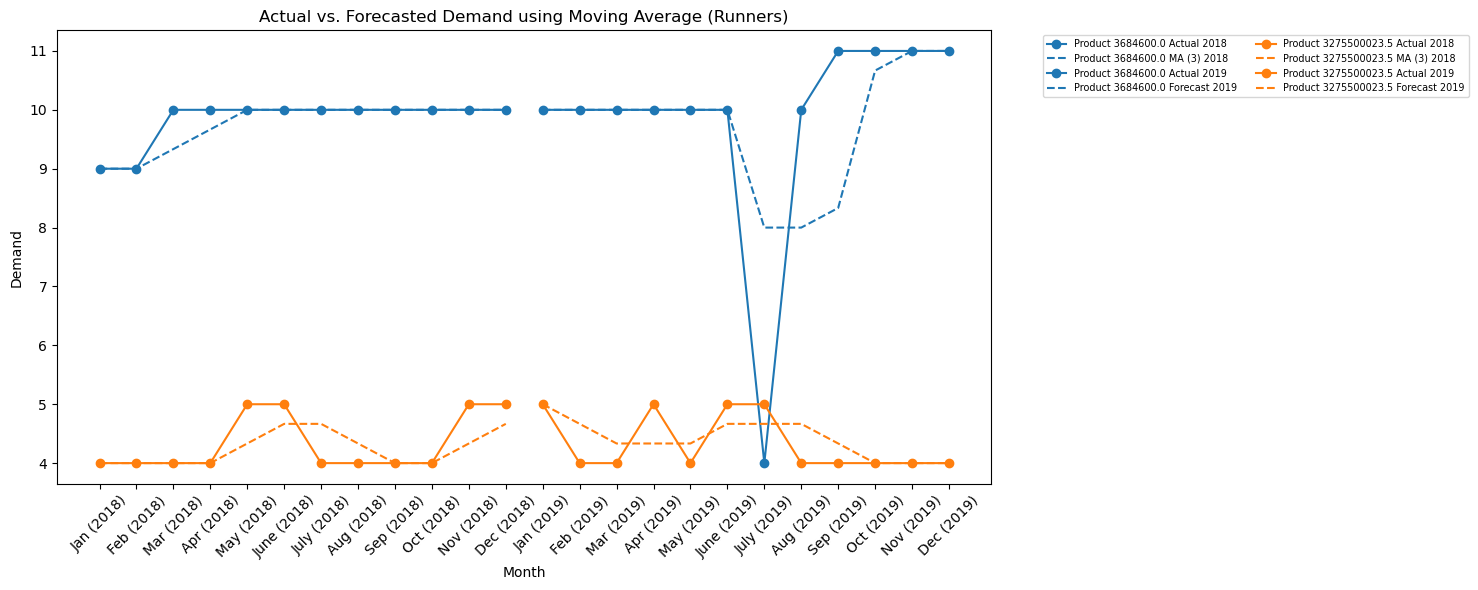

Average MAD for first 10 products: 0.5277777777777778
Average MSE for first 10 products: 1.2129629629629628
Average MAPE for first 10 products: 9.678030303030303


In [9]:
from sklearn.linear_model import LinearRegression

# Filter for 'Runners' products
df_runners = df[df['Coeff_Code'] == 'Runner'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_runners.columns.get_loc("Jan (2018)")
end_index_2018 = df_runners.columns.get_loc("Dec (2018)")
start_index_2019 = df_runners.columns.get_loc("Jan (2019)")
end_index_2019 = df_runners.columns.get_loc("Dec (2019)")

# Initialize a plot
plt.figure(figsize=(15, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10)) 

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_runners.iterrows():
    # if num_products_processed < 10:
    if product_id in (3275500023.5, 3684600.0,):
        # Get the color for the current product
        color = colors[num_products_processed % len(colors)]

        # Calculate the moving average for 2018
        numeric_data = pd.to_numeric(row, errors='coerce').fillna(0)

        data_2018 = numeric_data[start_index_2018:end_index_2018+1]
        data_2019 = numeric_data[start_index_2019:end_index_2019+1]
        
        if not train_data.dropna().empty:
            # Compute moving average for 2018 and extend this logic into 2019
            combined_data = pd.concat([data_2018, data_2019])
            moving_avg_combined = combined_data.rolling(window=window_size, min_periods=1).mean()

            # Separate the moving average into 2018 and 2019 for clarity
            moving_avg_2018 = moving_avg_combined.iloc[:len(data_2018)]
            forecast_2019 = moving_avg_combined.iloc[len(data_2018):]
            
            # Plot training data and moving average
            plt.plot(combined_data.index[:len(data_2018)], data_2018, marker='o', linestyle='-', color=color, label=f'Product {product_id} Actual 2018')
            plt.plot(data_2018.index, moving_avg_2018, linestyle='--', color=color, label=f'Product {product_id} MA (3) 2018')
            plt.plot(combined_data.index[len(data_2018):], data_2019, marker='o', linestyle='-', color=color, label=f'Product {product_id} Actual 2019')
            plt.plot(combined_data.index[len(data_2018):], forecast_2019, linestyle='--', color=color, label=f'Product {product_id} Forecast 2019')

           # Calculate errors
            errors = data_2019.values - forecast_2019
            
            # Calculate MAD, MSE, MAPE
            mad = np.mean(np.abs(errors))
            mse = np.mean(errors**2)
            mape = np.mean(np.abs(errors / data_2019.values)) * 100
            
            # Store the calculated metrics
            mad_list.append(mad)
            mse_list.append(mse)
            mape_list.append(mape)
    
        # Increment the counter
        num_products_processed += 1

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand using Moving Average (Runners)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first 10 products: {average_mad}')
print(f'Average MSE for first 10 products: {average_mse}')
print(f'Average MAPE for first 10 products: {average_mape}')

#### Strangers (First 10 Products)

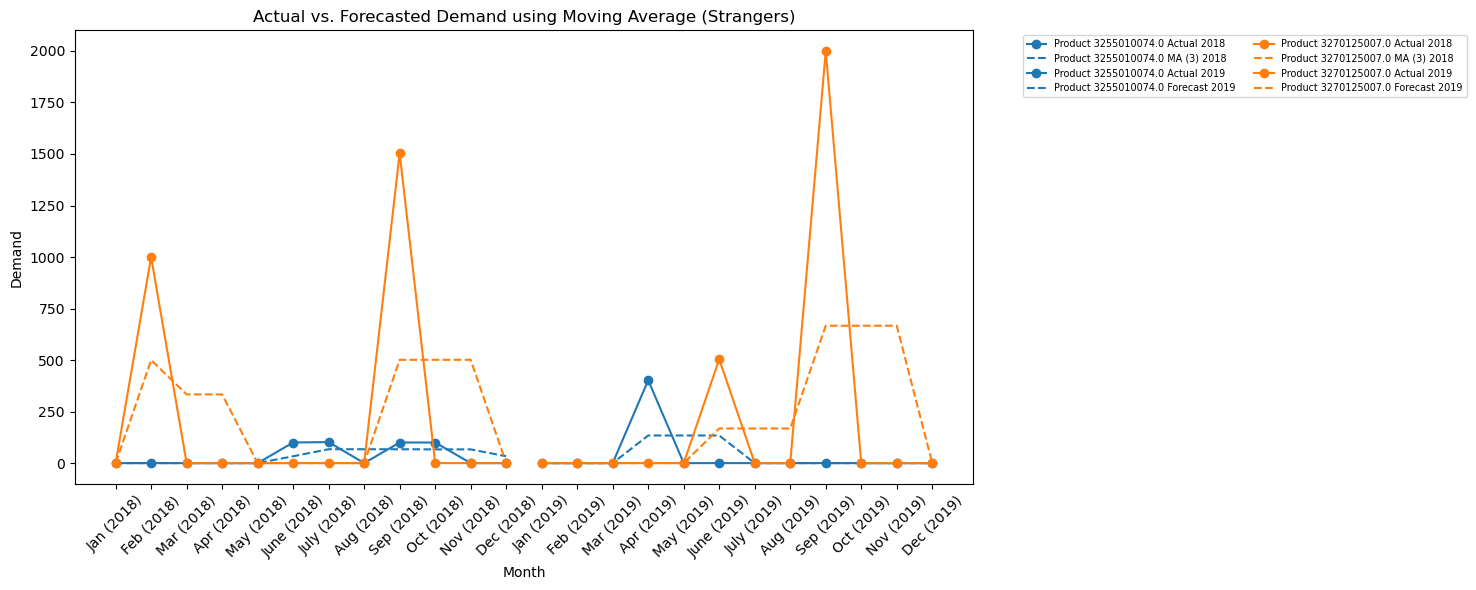

Average MAD for first 10 products: 161.44444444444446
Average MSE for first 10 products: 122656.11111111112
Average MAPE for first 10 products: inf


In [10]:
from sklearn.linear_model import LinearRegression

# Filter for 'Spikers' and 'Stranger' products
df_selected = df[df['Coeff_Code'].isin(['Spiker', 'Stranger'])].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_selected.columns.get_loc("Jan (2018)")
end_index_2018 = df_selected.columns.get_loc("Dec (2018)")
start_index_2019 = df_selected.columns.get_loc("Jan (2019)")
end_index_2019 = df_selected.columns.get_loc("Dec (2019)")

# Initialize a plot
plt.figure(figsize=(15, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10)) 

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_selected.iterrows():
    # if num_products_processed < 10:
    if product_id in (3270125007.0, 3255010074.0):
        # Get the color for the current product
        color = colors[num_products_processed % len(colors)]

        # Calculate the moving average for 2018
        numeric_data = pd.to_numeric(row, errors='coerce').fillna(0)

        data_2018 = numeric_data[start_index_2018:end_index_2018+1]
        data_2019 = numeric_data[start_index_2019:end_index_2019+1]
        
        if not train_data.dropna().empty:
            # Compute moving average for 2018 and extend this logic into 2019
            combined_data = pd.concat([data_2018, data_2019])
            moving_avg_combined = combined_data.rolling(window=window_size, min_periods=1).mean()

            # Separate the moving average into 2018 and 2019 for clarity
            moving_avg_2018 = moving_avg_combined.iloc[:len(data_2018)]
            forecast_2019 = moving_avg_combined.iloc[len(data_2018):]
            
            # Plot training data and moving average
            plt.plot(combined_data.index[:len(data_2018)], data_2018, marker='o', linestyle='-', color=color, label=f'Product {product_id} Actual 2018')
            plt.plot(data_2018.index, moving_avg_2018, linestyle='--', color=color, label=f'Product {product_id} MA (3) 2018')
            plt.plot(combined_data.index[len(data_2018):], data_2019, marker='o', linestyle='-', color=color, label=f'Product {product_id} Actual 2019')
            plt.plot(combined_data.index[len(data_2018):], forecast_2019, linestyle='--', color=color, label=f'Product {product_id} Forecast 2019')

            # Calculate errors
            errors = data_2019.values - forecast_2019
            
            # Calculate MAD, MSE, MAPE
            mad = np.mean(np.abs(errors))
            mse = np.mean(errors**2)
            mape = np.mean(np.abs(errors / data_2019.values)) * 100
            
            # Store the calculated metrics
            mad_list.append(mad)
            mse_list.append(mse)
            mape_list.append(mape)
    
        # Increment the counter
        num_products_processed += 1

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand using Moving Average (Strangers)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first 10 products: {average_mad}')
print(f'Average MSE for first 10 products: {average_mse}')
print(f'Average MAPE for first 10 products: {average_mape}')

## On a Product Level

### Repeaters

In [11]:
from sklearn.linear_model import LinearRegression

# Filter for 'Repeater' products
df_repeaters = df[df['Coeff_Code'] == 'Repeater'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_repeaters.columns.get_loc("Jan (2018)")
end_index_2018 = df_repeaters.columns.get_loc("Dec (2018)")
start_index_2019 = df_repeaters.columns.get_loc("Jan (2019)")
end_index_2019 = df_repeaters.columns.get_loc("Dec (2019)")

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_repeaters.iterrows():
        # Get the color for the current product
        color = colors[num_products_processed % len(colors)]

        # Calculate the moving average for 2018
        numeric_data = pd.to_numeric(row, errors='coerce').fillna(0)

        data_2018 = numeric_data[start_index_2018:end_index_2018+1]
        data_2019 = numeric_data[start_index_2019:end_index_2019+1]
        
        if not train_data.dropna().empty:
            # Compute moving average for 2018 and extend this logic into 2019
            combined_data = pd.concat([data_2018, data_2019])
            moving_avg_combined = combined_data.rolling(window=window_size, min_periods=1).mean()

            # Separate the moving average into 2018 and 2019 for clarity
            moving_avg_2018 = moving_avg_combined.iloc[:len(data_2018)]
            forecast_2019 = moving_avg_combined.iloc[len(data_2018):]

           # Calculate errors
            errors = data_2019.values - forecast_2019
            
            # Calculate MAD, MSE, MAPE
            mad = np.mean(np.abs(errors))
            mse = np.mean(errors**2)
            mape = np.mean(np.abs(errors / (data_2019.values + np.finfo(float).eps))) * 100
            
            # Store the calculated metrics
            mad_list.append(mad)
            mse_list.append(mse)
            mape_list.append(mape)
    
        # Increment the counter
        num_products_processed += 1
    
average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for all Repeaters: {average_mad}')
print(f'Average MSE for all Repeaters: {average_mse}')
print(f'Average MAPE for all Repeaters: {average_mape}')

Average MAD for all Repeaters: 72.00745257452574
Average MSE for all Repeaters: 32527.40652832837
Average MAPE for all Repeaters: 1.4842656088986298e+19


### Runners

In [14]:
from sklearn.linear_model import LinearRegression

df_runners = df[df['Coeff_Code'] == 'Runner'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_runners.columns.get_loc("Jan (2018)")
end_index_2018 = df_runners.columns.get_loc("Dec (2018)")
start_index_2019 = df_runners.columns.get_loc("Jan (2019)")
end_index_2019 = df_runners.columns.get_loc("Dec (2019)")

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_runners.iterrows():
        # Get the color for the current product
        color = colors[num_products_processed % len(colors)]

        # Calculate the moving average for 2018
        numeric_data = pd.to_numeric(row, errors='coerce').fillna(0)

        data_2018 = numeric_data[start_index_2018:end_index_2018+1]
        data_2019 = numeric_data[start_index_2019:end_index_2019+1]
        
        if not train_data.dropna().empty:
            # Compute moving average for 2018 and extend this logic into 2019
            combined_data = pd.concat([data_2018, data_2019])
            moving_avg_combined = combined_data.rolling(window=window_size, min_periods=1).mean()

            # Separate the moving average into 2018 and 2019 for clarity
            moving_avg_2018 = moving_avg_combined.iloc[:len(data_2018)]
            forecast_2019 = moving_avg_combined.iloc[len(data_2018):]

           # Calculate errors
            errors = data_2019.values - forecast_2019
            
            # Calculate MAD, MSE, MAPE
            mad = np.mean(np.abs(errors))
            mse = np.mean(errors**2)
            mape = np.mean(np.abs(errors / (data_2019.values + np.finfo(float).eps))) * 100
            
            # Store the calculated metrics
            mad_list.append(mad)
            mse_list.append(mse)
            mape_list.append(mape)

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for all Runners: {average_mad}')
print(f'Average MSE for all Runners: {average_mse}')
print(f'Average MAPE for all Runners: {average_mape}')

Average MAD for all Runners: 0.21385083713850836
Average MSE for all Runners: 0.13876204972095382
Average MAPE for all Runners: 5.100721830173885


### Strangers

In [15]:
from sklearn.linear_model import LinearRegression

df_strangers = df[df['Coeff_Code'].isin(['Spiker', 'Stranger'])].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_strangers.columns.get_loc("Jan (2018)")
end_index_2018 = df_strangers.columns.get_loc("Dec (2018)")
start_index_2019 = df_strangers.columns.get_loc("Jan (2019)")
end_index_2019 = df_strangers.columns.get_loc("Dec (2019)")

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_strangers.iterrows():
        # Get the color for the current product
        color = colors[num_products_processed % len(colors)]

        # Calculate the moving average for 2018
        numeric_data = pd.to_numeric(row, errors='coerce').fillna(0)

        data_2018 = numeric_data[start_index_2018:end_index_2018+1]
        data_2019 = numeric_data[start_index_2019:end_index_2019+1]
        
        if not train_data.dropna().empty:
            # Compute moving average for 2018 and extend this logic into 2019
            combined_data = pd.concat([data_2018, data_2019])
            moving_avg_combined = combined_data.rolling(window=window_size, min_periods=1).mean()

            # Separate the moving average into 2018 and 2019 for clarity
            moving_avg_2018 = moving_avg_combined.iloc[:len(data_2018)]
            forecast_2019 = moving_avg_combined.iloc[len(data_2018):]

           # Calculate errors
            errors = data_2019.values - forecast_2019
            
            # Calculate MAD, MSE, MAPE
            mad = np.mean(np.abs(errors))
            mse = np.mean(errors**2)
            mape = np.mean(np.abs(errors / (data_2019.values + np.finfo(float).eps))) * 100
            
            # Store the calculated metrics
            mad_list.append(mad)
            mse_list.append(mse)
            mape_list.append(mape)

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for all Strangers: {average_mad}')
print(f'Average MSE for all Strangers: {average_mse}')
print(f'Average MAPE for all Strangers: {average_mape}')

Average MAD for all Strangers: 9.236214009661834
Average MSE for all Strangers: 13161.923516426732
Average MAPE for all Strangers: 1.864008991510335e+18
